# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [7]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
import psycopg2

from sqlalchemy.orm import declarative_base

In [8]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "alMZBjkqoiGjUdoR8UIDOouaq"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "resource/erm2-nwe9.geojson"
NYC_DATA_TREES = "resource/5rq2-4hqu.geojson"

DB_NAME = "Project_4501"
DB_USER = "celia"
DB_URL = f"postgresql+psycopg2://{DB_USER}:@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [9]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In [10]:
def download_nyc_geojson_data(url, force=False, query=None):
    """
    Download NYC GeoJSON data and save it to a local file.
    
    Parameters:
        url (str): The URL from which to download the data.
        force (bool, optional): If True, force downloading even if the file exists locally. Defaults to False.
        query (str, optional): A query string to filter the data during download. Defaults to None.
    
    Returns:
        pathlib.Path: The local path to the downloaded GeoJSON file.
    """
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = DATA_DIR / url_path
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        
        headers = {'X-App-Token': NYC_DATA_APP_TOKEN}
        params = {
        "$limit": 1000000,
        "$offset": 0,
        "$select": "*",
        "$where": query
        }
        response = requests.get(url, headers=headers, params=params)
        
        with open(filename, "w") as f:
            json.dump(response.json(), f)
        print(f"Done downloading {url}.")

    else:
        print(f"Reading from {filename}...")

    return filename

In [11]:
def download_311_data(url, year):
    """
    Downloads and processes 311 service request data for a specified year from a given URL.

    This function fetches data based on the 'created_date' within the specified year.
    For the year 2023, it fetches data from January 1 to September 30.
    For other years, it fetches data for the entire year.
    
    The data is processed into a GeoDataFrame, which includes columns for unique keys, incident zip codes,
    creation dates, complaint types, and location geometries. The original 'properties' column is
    normalized and merged into the main GeoDataFrame, and unnecessary columns are dropped.

    The resulting GeoDataFrame is saved as a GeoJSON file in a specified directory.

    Parameters:
    url (str): URL to fetch the 311 service request data from.
    year (str): The year for which the data is to be downloaded.

    Returns:
    gpd.GeoDataFrame: The processed GeoDataFrame containing the 311 service request data for the specified year.
    """
    if year == "2023":
        query_where = f"created_date between '{year}-01-01T00:00:00' and '{year}-09-30T23:59:59'"
    else:
        query_where = f"created_date between '{year}-01-01T00:00:00' and '{year}-12-31T23:59:59'"
    print('starting download for ' + str(year))

    headers = {'X-App-Token': NYC_DATA_APP_TOKEN}
    params = {
    "$limit": 4000000,
    "$offset": 0,
    "$select": "unique_key,incident_zip,created_date,complaint_type,location",
    "$where": query_where
    }
    response = requests.get(url, headers=headers, params=params)
    assert response.status_code == 200
    print(f"Done downloading {year}.")
    print('download successful for ' + str(year) + '-')

    temp_json = response.json()
    gdf = gpd.GeoDataFrame(temp_json['features'])

    if gdf.shape[0] >= 4000000:
        print('data too large for ' + str(year) )

    gdf['features'] = gdf['geometry'].apply(lambda x: {'geometry': x, 'properties': {}})
    gdf2 = gpd.GeoDataFrame.from_features(gdf['features'])
    gdf = gdf.set_geometry(gdf2.geometry)
    gdf = gdf.set_crs(temp_json['crs']['properties']['name'])
    df = pd.json_normalize(temp_json['features'])
    df.drop(['type', 'geometry.type', 'geometry.coordinates','geometry'], axis=1, inplace=True)
    df.columns = df.columns.str.replace('properties.', '', regex=False)
    merged = gdf.merge(df, left_index=True, right_index=True)
    merged.drop(['features','type'], axis=1, inplace=True)
    merged = merged.dropna()
    
    merged.to_file(f'{DATA_DIR}/{year}.geojson', driver='GeoJSON')

    return merged

In [12]:
def load_and_clean_zipcodes(zipcode_datafile):
    """
    Load and clean zipcode data from a specified file.

    This function reads geographic data of zipcodes from a given file,
    converts the coordinate reference system to EPSG 4326, and selects specific columns.
    It selects relevant columns, renames them, and removes rows with missing values.

    Args:
        zipcode_datafile (str): The file path of the zipcode data file.
    
    Returns:
        GeoDataFrame: A cleaned GeoDataFrame with selected information about zipcodes.
    """
    zipcode_data = gpd.read_file(zipcode_datafile)
    zipcode_data = zipcode_data.to_crs(epsg=4326)
    zipcode_data = zipcode_data[['ZIPCODE', 'COUNTY', 'geometry']]
    zipcode_data = zipcode_data.rename(columns={'ZIPCODE': 'zipcode', 'COUNTY': 'county'})
    zipcode_data = zipcode_data.dropna()
    
    return zipcode_data

In [13]:
def download_and_clean_311_data():
    """
    Downloads and cleans New York City's 311 service request data for a range of years.

    This function iterates through a predefined list of years (from 2015 to 2023) and downloads 
    the 311 service request data for each year using the `download_311_data` function. It compiles 
    the data from all years into a single GeoDataFrame. The function then filters and renames 
    specific columns for consistency and removes any rows with missing data.

    Returns:
        GeoDataFrame: A GeoDataFrame containing the cleaned and consolidated 311 service request 
        data across the specified years. The DataFrame includes the following columns: 'id' (unique 
        key), 'zipcode' (incident zip code), 'date' (created date), 'complaint_type', and 'geometry' 
        (spatial geometry of the incident).
    """
    Years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
    geodf_311_data = []
    for year in Years:
        df = download_311_data(f"{BASE_NYC_DATA_URL}{NYC_DATA_311}", year)
        geodf_311_data.append(df)
    nyc_311_data = pd.concat(geodf_311_data, ignore_index=True)
    nyc_311_data = nyc_311_data.to_crs(epsg=4326)
    nyc_311_data = nyc_311_data[['unique_key', 'incident_zip', 'created_date', 'complaint_type', 'geometry']]
    nyc_311_data = nyc_311_data.rename(columns={'unique_key': 'id', 'incident_zip': 'zipcode', 'created_date': 'date'})
    nyc_311_data['date'] = pd.to_datetime(nyc_311_data['date'])
    nyc_311_data = nyc_311_data.dropna()

    return nyc_311_data

In [14]:
def download_and_clean_tree_data():
    """
    Download and clean New York City tree data.
    
    This function downloads NYC tree data in GeoJSON format from a NYC Open Data,
    reads it into a GeoDataFrame, converts its coordinate reference system to EPSG 4326,
    selects specific columns, renames some for clarity, and removes rows with missing values.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the cleaned NYC tree data.
                          The data includes columns like tree ID, zipcode, species,
                          health, status, and geometry after renaming and dropping
                          missing values.
    """
    nyc_trees_data = download_nyc_geojson_data(f"{BASE_NYC_DATA_URL}{NYC_DATA_TREES}", force=True)
    nyc_trees_data = gpd.read_file(nyc_trees_data)
    nyc_trees_data = nyc_trees_data.to_crs(epsg=4326)
    nyc_trees_data = nyc_trees_data[["tree_id", "zipcode", "spc_common", "health", "status", "geometry"]]
    nyc_trees_data = nyc_trees_data.rename(columns={"tree_id": "id", "spc_common": "species"})
    nyc_trees_data = nyc_trees_data.dropna()
    
    return nyc_trees_data

In [15]:
def load_and_clean_zillow_data(): 
    """
    Load and clean Zillow rental data for New York City.
    
    This function reads Zillow rental data from a CSV file, filters it for entries
    pertaining to New York City, and selects specific columns relevant to rental
    prices. The columns are then renamed for clarity, and rows with missing values
    are removed to ensure the quality of data.

    Returns:
        DataFrame: A DataFrame containing cleaned Zillow rental data with columns for 
                   Zillow region ID, zipcode, and rental prices for August and September 2023.
    """
    zillow_data = pd.read_csv(ZILLOW_DATA_FILE)
    zillow_data = zillow_data[zillow_data["City"]=="New York"]

    cols_to_keep = ['RegionID', 'RegionName']
    cols_to_melt = [col for col in zillow_data.columns if col.startswith('20')]
    zillow_data = zillow_data[cols_to_keep + cols_to_melt]
    zillow_data_long = pd.melt(zillow_data, id_vars=cols_to_keep, value_vars=cols_to_melt,
                                var_name='date', value_name='rent')
    zillow_data_long['date'] = pd.to_datetime(zillow_data_long['date'], format='%Y/%m/%d')
    zillow_data_long['RegionName'] = zillow_data_long['RegionName'].astype(str)
    zillow_data_long = zillow_data_long.rename(columns={"RegionID": "region_id", "RegionName": "zipcode"})

    zillow_data_long
    
    return zillow_data_long

In [16]:
def load_all_data():
    """
    Load and combine multiple datasets into a single collection.

    This function aggregates four different datasets: zipcode data, 311 service request data,
    tree census data, and Zillow rental data, each of which is loaded and cleaned by their
    respective functions. The datasets are primarily focused on New York City information.
    
    Returns:
        tuple: A tuple containing four cleaned datasets (GeoDataFrames and DataFrame).
               These are: zipcode data, 311 service request data, tree census data,
               and Zillow rental data.
    """
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [17]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

starting download for 2015
Done downloading 2015.
download successful for 2015-
starting download for 2016
Done downloading 2016.
download successful for 2016-
starting download for 2017
Done downloading 2017.
download successful for 2017-
starting download for 2018
Done downloading 2018.
download successful for 2018-
starting download for 2019
Done downloading 2019.
download successful for 2019-
starting download for 2020
Done downloading 2020.
download successful for 2020-
starting download for 2021
Done downloading 2021.
download successful for 2021-
starting download for 2022
Done downloading 2022.
download successful for 2022-
starting download for 2023
Done downloading 2023.
download successful for 2023-
Done downloading https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson.


In [18]:
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   263 non-null    object  
 1   county    263 non-null    object  
 2   geometry  263 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 6.3+ KB


In [19]:
geodf_zipcode_data.head()

,zipcode,county,geometry
0,11436,Queens,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,Kings,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,Kings,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,Kings,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,Kings,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [20]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23030863 entries, 0 to 23030862
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   zipcode         object        
 2   date            datetime64[ns]
 3   complaint_type  object        
 4   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 878.6+ MB


In [21]:
geodf_311_data.head()

,id,zipcode,date,complaint_type,geometry
0,32310363,10034,2015-12-31 23:59:45,Noise - Street/Sidewalk,POINT (-73.92350 40.86568)
1,32309934,11105,2015-12-31 23:59:44,Blocked Driveway,POINT (-73.91509 40.77595)
2,32306007,10302,2015-12-31 23:59:32,Noise - Residential,POINT (-74.13203 40.63288)
3,32309159,10458,2015-12-31 23:59:29,Blocked Driveway,POINT (-73.88852 40.87032)
4,32309493,10002,2015-12-31 23:59:19,Noise - Residential,POINT (-73.98657 40.71048)


In [22]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 652167 entries, 0 to 683787
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        652167 non-null  object  
 1   zipcode   652167 non-null  object  
 2   species   652167 non-null  object  
 3   health    652167 non-null  object  
 4   status    652167 non-null  object  
 5   geometry  652167 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 34.8+ MB


In [23]:
geodf_tree_data.head()

,id,zipcode,species,health,status,geometry
0,180683,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)


In [24]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15225 entries, 0 to 15224
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   region_id  15225 non-null  int64         
 1   zipcode    15225 non-null  object        
 2   date       15225 non-null  datetime64[ns]
 3   rent       9039 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 475.9+ KB


In [25]:
df_zillow_data.head()

,region_id,zipcode,date,rent
0,62093,11385,2015-01-31,NaN
1,62019,11208,2015-01-31,NaN
2,62046,11236,2015-01-31,NaN
3,61807,10467,2015-01-31,NaN
4,62085,11373,2015-01-31,NaN


## Part 2: Storing Data

In [26]:
def setup_new_postgis_database(username, db_name):
    """
    Setup a new PostGIS database in PostgreSQL.

    Args:
        username (str): Username for the PostgreSQL database.
        db_name (str): Name of the database to setup.
        password (str): Password for the specified user.

    Returns:
        conn: A connection object to the created database.
    """
    conn = psycopg2.connect(
        dbname = db_name, 
        user = username,
    )
    cursor = conn.cursor()
    conn.commit()
    cursor.close()

    return conn

In [27]:
setup_new_postgis_database(DB_USER, DB_NAME)

<connection object at 0x12feea110; dsn: 'dbname=Project_4501 user=celia', closed: 0>

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [28]:
engine = db.create_engine(DB_URL)

#### SQL

In [29]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS zipcodes
(
    zipcode TEXT PRIMARY KEY,
    county TEXT,
    geometry GEOMETRY(Polygon, 4326)
);
CREATE INDEX zipcodes_geom_idx ON zipcodes USING GIST (geometry);
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS complaints
(
    id TEXT PRIMARY KEY,
    zipcode TEXT,
    date TIMESTAMP,
    complaint_type TEXT,
    geometry GEOMETRY(Point, 4326)
);
CREATE INDEX complaints_geom_idx ON complaints USING GIST (geometry);
"""

NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS trees
(
    id TEXT PRIMARY KEY,
    zipcode TEXT,
    species TEXT,
    health TEXT,
    status TEXT,
    geometry GEOMETRY(Point, 4326)
);
CREATE INDEX trees_geom_idx ON trees USING GIST (geometry);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS rents
(
    id SERIAL PRIMARY KEY,
    region_id INTEGER,
    zipcode TEXT,
    date DATE,
    rent FLOAT
);
"""

In [30]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write("DROP TABLE IF EXISTS zipcodes, complaints, trees, rents;")
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [31]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with engine.connect() as connection:
    with open(DB_SCHEMA_FILE, 'r') as schema_file:
        schema_sql = schema_file.read()
        connection.execute(db.text(schema_sql))

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### SQL

In [32]:
def write_dataframes_to_table(tablename_to_dataframe):
    """
    Write data from provided dataframes to corresponding tables in the database.
    
    Args:
        tablename_to_dataframe (dict): A dictionary mapping table names to dataframes.
    """
    for table_name, dataframe in tablename_to_dataframe.items():
        if table_name != "rents":
            dataframe.to_postgis(table_name, engine, if_exists='replace', index=False)
        else:
            dataframe.to_sql(table_name, engine, if_exists='replace', index=False)

In [33]:
tablename_to_dataframe = {
    "zipcodes": geodf_zipcode_data,
    "complaints": geodf_311_data,
    "trees": geodf_tree_data,
    "rents": df_zillow_data,
}

In [34]:
write_dataframes_to_table(tablename_to_dataframe)

In [35]:
geodf_311_data

,id,zipcode,date,complaint_type,geometry
0,32310363,10034,2015-12-31 23:59:45,Noise - Street/Sidewalk,POINT (-73.92350 40.86568)
1,32309934,11105,2015-12-31 23:59:44,Blocked Driveway,POINT (-73.91509 40.77595)
2,32306007,10302,2015-12-31 23:59:32,Noise - Residential,POINT (-74.13203 40.63288)
3,32309159,10458,2015-12-31 23:59:29,Blocked Driveway,POINT (-73.88852 40.87032)
4,32309493,10002,2015-12-31 23:59:19,Noise - Residential,POINT (-73.98657 40.71048)
...,...,...,...,...,...
23030858,56418136,11234,2023-01-01 00:00:46,Noise - Residential,POINT (-73.92604 40.62066)
23030859,56418795,10001,2023-01-01 00:00:45,Illegal Parking,POINT (-74.00075 40.75488)
23030860,56416252,10453,2023-01-01 00:00:42,Noise - Residential,POINT (-73.91771 40.85385)
23030861,56417527,11218,2023-01-01 00:00:09,Illegal Fireworks,POINT (-73.97364 40.64091)


## Part 3: Understanding the Data

In [36]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    """
    Write a SQL query to a file.
    
    Parameters:
        query (str): The SQL query string to be written to the file.
        outfile (str): The path to the file where the query will be saved.
    """
    with open(outfile, 'w') as file:
        file.write(query)
    print(f"Query written to {outfile}")

### Query 1

In [37]:
QUERY_1_FILENAME = QUERY_DIR / "complaints_per_zipcode.sql"

QUERY_1 = """
SELECT
    zipcode,
    COUNT(*) AS num_complaints
FROM
    complaints
WHERE
    date BETWEEN TIMESTAMP '2022-10-01 00:00:00' AND TIMESTAMP '2023-09-30 23:59:59'
GROUP BY
    zipcode;
"""

In [38]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

('00083', 2)
('10000', 689)
('10001', 13126)
('10002', 25553)
('10003', 21570)
('10004', 2487)
('10005', 2082)
('10006', 1578)
('10007', 4024)
('10009', 20998)
('10010', 7908)
('10011', 22088)
('10012', 11510)
('10013', 12337)
('10014', 13360)
('10016', 17075)
('10017', 6680)
('10018', 7594)
('10019', 28113)
('10020', 432)
('10021', 9587)
('10022', 9686)
('10023', 26805)
('10024', 16042)
('10025', 30936)
('10026', 21261)
('10027', 25785)
('10028', 13965)
('10029', 20809)
('10030', 18015)
('10031', 33798)
('10032', 31974)
('10033', 23655)
('10034', 22248)
('10035', 18268)
('10036', 20683)
('10037', 7939)
('10038', 6675)
('10039', 11957)
('10040', 19833)
('10041', 33)
('10044', 1040)
('10045', 27)
('10048', 23)
('10055', 2)
('10065', 8041)
('10069', 593)
('10075', 5703)
('10080', 1)
('10103', 81)
('10105', 164)
('10106', 45)
('10107', 228)
('10110', 24)
('10111', 12)
('10112', 28)
('10115', 12)
('10118', 52)
('10119', 35)
('10120', 48)
('10121', 286)
('10122', 4)
('10123', 17)
('10128', 

In [39]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query written to queries/complaints_per_zipcode.sql


### Query 2

In [40]:
QUERY_2_FILENAME = QUERY_DIR / "top_10_zipcodes_with_most_trees.sql"

QUERY_2 = """
SELECT
    zipcode,
    COUNT(*) AS total_trees
FROM
    trees
WHERE
    status = 'Alive'
GROUP BY
    zipcode
ORDER BY
    total_trees DESC
LIMIT 10;
"""

In [41]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8293)
('11208', 7896)
('11434', 7833)


In [42]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query written to queries/top_10_zipcodes_with_most_trees.sql


### Query 3

In [43]:
QUERY_3_FILENAME = QUERY_DIR / "average_rent_by_zipcode.sql"

QUERY_3 = """
SELECT
    trees.zipcode,
    TO_CHAR(AVG(rents.rent), 'FM9,999,999.00') AS august_rent
FROM
    trees
JOIN
    rents ON trees.zipcode = rents.zipcode
WHERE
    EXTRACT(MONTH FROM rents.date) = 8
    AND EXTRACT(YEAR FROM rents.date) = 2023
    AND trees.status = 'Alive'
GROUP BY
    trees.zipcode
ORDER BY
    COUNT(*) DESC
LIMIT 10;
"""

In [44]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10312', '1,775.09')
('10314', '2,465.47')
('10306', '2,331.54')
('10309', '1,832.01')
('11234', '2,312.31')
('11385', '3,064.48')
('11357', '2,458.81')
('11207', '3,079.09')
('11208', '2,737.55')
('11434', '2,645.92')


In [45]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

Query written to queries/average_rent_by_zipcode.sql


### Query 4

In [99]:
QUERY_4_FILENAME = QUERY_DIR / "correlation_between_rent_trees_complaints.sql"

QUERY_4 = '''WITH RentSummary AS (
        SELECT
            r.zipcode,
            AVG(r.rent) AS avg_rent
        FROM
            rents r
        WHERE
            r.date BETWEEN '2023-01-01' AND '2023-01-31'
            AND r.rent IS NOT NULL
        GROUP BY
            r.zipcode
    ),
    RankedRents AS (
        SELECT
            zipcode,
            avg_rent,
            ROW_NUMBER() OVER (ORDER BY avg_rent ASC) AS low_rank,
            ROW_NUMBER() OVER (ORDER BY avg_rent DESC) AS high_rank
        FROM
            RentSummary
    ),
    TreeCounts AS (
        SELECT
            zipcode,
            COUNT(*) AS tree_count
        FROM
            trees
        WHERE
            status = 'Alive'
        GROUP BY
            zipcode
    ),
    ComplaintCounts AS (
        SELECT
            zipcode,
            COUNT(*) AS complaint_count
        FROM
            complaints
        WHERE
            date BETWEEN '2023-01-01' AND '2023-01-31'
        GROUP BY
            zipcode
    )
    SELECT
        R.zipcode,
        TO_CHAR(R.avg_rent, 'FM9,999,999.00') as average_rent,
        COALESCE(T.tree_count, 0) AS tree_count,
        COALESCE(C.complaint_count, 0) AS complaint_count
    FROM
        RankedRents R
    LEFT JOIN
        TreeCounts T ON R.zipcode = T.zipcode
    LEFT JOIN
        ComplaintCounts C ON R.zipcode = C.zipcode
    WHERE
        R.low_rank <= 5 OR R.high_rank <= 5
    ORDER BY
        R.avg_rent, R.zipcode;
    '''

In [100]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

('10309', '1,380.51', 12105, 766)
('10462', '1,801.89', 4048, 2273)
('10453', '1,820.23', 2874, 2935)
('11357', '1,829.66', 9016, 859)
('10458', '1,883.08', 3212, 3576)
('10011', '4,741.87', 2040, 1471)
('10069', '4,959.67', 112, 35)
('10013', '5,480.11', 1132, 733)
('10282', '7,143.35', 230, 38)
('10007', '7,270.24', 338, 226)


In [101]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

Query written to queries/correlation_between_rent_trees_complaints.sql


### Query 5

In [48]:
QUERY_5_FILENAME = QUERY_DIR / "the_most_greenery_areas.sql"

QUERY_5 = """
SELECT
    zipcodes.zipcode,
    COUNT(*) AS total_trees
FROM
    zipcodes
JOIN
    trees ON ST_Within(trees.geometry, zipcodes.geometry)
WHERE
    status = 'Alive'
GROUP BY
    zipcodes.zipcode
ORDER BY
    total_trees DESC
LIMIT 10;
"""

In [49]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8294)
('11208', 7897)
('11434', 7833)


In [50]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

Query written to queries/the_most_greenery_areas.sql


### Query 6

In [93]:
QUERY_6_FILENAME = QUERY_DIR / "trees_within_coordinate.sql"

QUERY_6 = '''
SELECT
    id,
    species,
    health,
    status,
    ST_AsText(geometry) AS "Location"
FROM
    trees
WHERE
    ST_DWithin(
        geometry::geography,
        ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467)::geography, 4326),
        804.67
    );
'''

In [94]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

('198514', 'pin oak', 'Good', 'Alive', 'POINT(-73.96207980385901 40.80230108588602)')
('209919', 'London planetree', 'Good', 'Alive', 'POINT(-73.96331506361766 40.808811547267055)')
('209921', 'London planetree', 'Good', 'Alive', 'POINT(-73.96340334087577 40.80874458097537)')
('203887', 'willow oak', 'Good', 'Alive', 'POINT(-73.96071917063361 40.805725833688264)')
('196440', 'American elm', 'Fair', 'Alive', 'POINT(-73.96412322243684 40.81114537770991)')
('209913', 'pin oak', 'Good', 'Alive', 'POINT(-73.96312071522566 40.809077091635245)')
('178550', 'Norway maple', 'Good', 'Alive', 'POINT(-73.95739876534434 40.806903447365045)')
('189403', 'Callery pear', 'Fair', 'Alive', 'POINT(-73.95861205918303 40.80754134482308)')
('196606', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96719943972623 40.80732246649563)')
('198512', 'pin oak', 'Good', 'Alive', 'POINT(-73.96230576828576 40.8023961095017)')
('196541', 'honeylocust', 'Good', 'Alive', 'POINT(-73.96549830227003 40.80929314213609)')
('20399

In [53]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

Query written to queries/trees_within_coordinate.sql


## Part 4: Visualizing the Data

### Visualization 1

In [72]:
def top_3_complaints_types(dataframe):
    """
    Generate a bar chart to visualize the top 3 complaint types over different dates.
    
    Parameters:
        dataframe (DataFrame): A pandas DataFrame that contains three columns:
                               'complaint_type' for the type of complaint,
                               'complaint_date' for the date of the complaint, and
                               'complaint_count' for the number of complaints of that type.
    
    Returns:
        None: The function will plot and show a bar chart.
    """
    dataframe['complaint_date'] = dataframe['complaint_date'].dt.strftime('%Y-%m-%d')

    dataframe['complaint_label'] = dataframe['complaint_type'] + " (" + dataframe['complaint_date'].astype(str) + ")"
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.bar(dataframe['complaint_label'], dataframe['complaint_count'])
    
    ax.set_title("Top 3 Complaint Types Over Different Dates")
    ax.set_xlabel("Complaint Type and Date")
    ax.set_ylabel("Number of Complaints")
    ax.set_xticks(range(len(dataframe['complaint_label'])))
    ax.set_xticklabels(dataframe['complaint_label'], rotation=45)
    
    plt.tight_layout()
    plt.show()

In [70]:
def get_data_for_visual_1():
    """
    Retrieve and return data for visualization.

    This function executes a SQL query to find the top 3 most common complaint types
    from the 'complaints' table between '2022-10-01' and '2023-09-30'. It groups the
    complaints by type and date, counts the occurrences, and orders them in descending
    order of frequency.

    Returns:
        pd.DataFrame: A DataFrame containing the top 3 complaint types, their respective
                      dates, and the count of occurrences on those dates.
    """
    VISUAL_QUERY_1 = """
    SELECT
        complaint_type,
        date_trunc('day', date) AS complaint_date,
        COUNT(*) AS complaint_count
    FROM
        complaints
    WHERE
        date_trunc('day', date) >= '2022-10-01' 
    AND 
        date_trunc('day', date) <= '2023-09-30'
    GROUP BY
        complaint_type, complaint_date
    ORDER BY
        complaint_count DESC
    LIMIT 3;
    """
    
    return pd.read_sql(VISUAL_QUERY_1, engine)

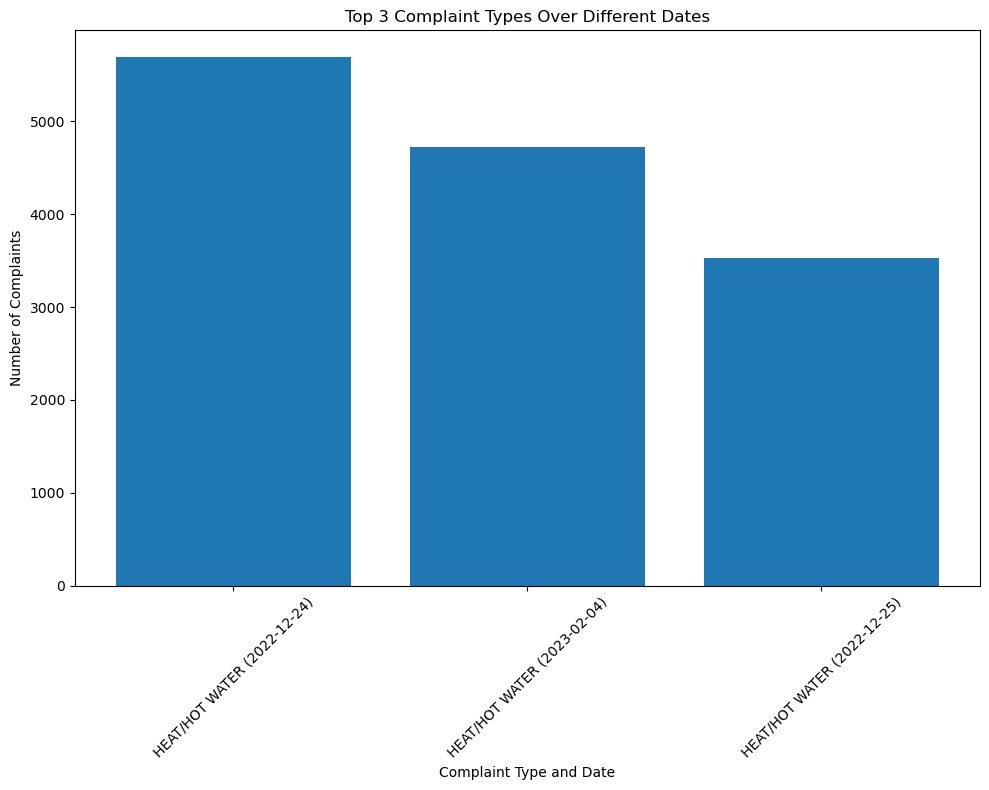

In [73]:
dataframe_for_visual_1 = get_data_for_visual_1()
top_3_complaints_types(dataframe_for_visual_1)

### Visualization 2

In [74]:
def most_common_complaints(dataframe):
    """
    Generate a bar chart to visualize the most common complaints.
    
    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing complaint data.
    """
    plt.figure(figsize=(10, 8))
    plt.bar(dataframe.complaint_type, dataframe.num_complaints)
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45)
    plt.title('Most Common Complaints')
    plt.show()

In [75]:
def get_data_for_visual_2():
    """
    Retrieve and return data for visualization.
        
    This function executes a SQL query to get complaint data for the top 10 complaint types
    in zip code 10027 within a specific time range.

    Returns:
        result_df (pd.DataFrame): DataFrame containing the query results.
    """
    VISUAL_QUERY_2 = """
    SELECT
        complaint_type,
        COUNT(*) AS num_complaints
    FROM
        complaints
    WHERE
        date BETWEEN TIMESTAMP '2018-10-01 00:00:00' AND TIMESTAMP '2023-09-30 23:59:59'
        AND zipcode = '10027'
    GROUP BY
        complaint_type
    ORDER BY
        num_complaints DESC
    LIMIT 10;
    """

    result_df = pd.read_sql_query(VISUAL_QUERY_2, engine)

    return result_df

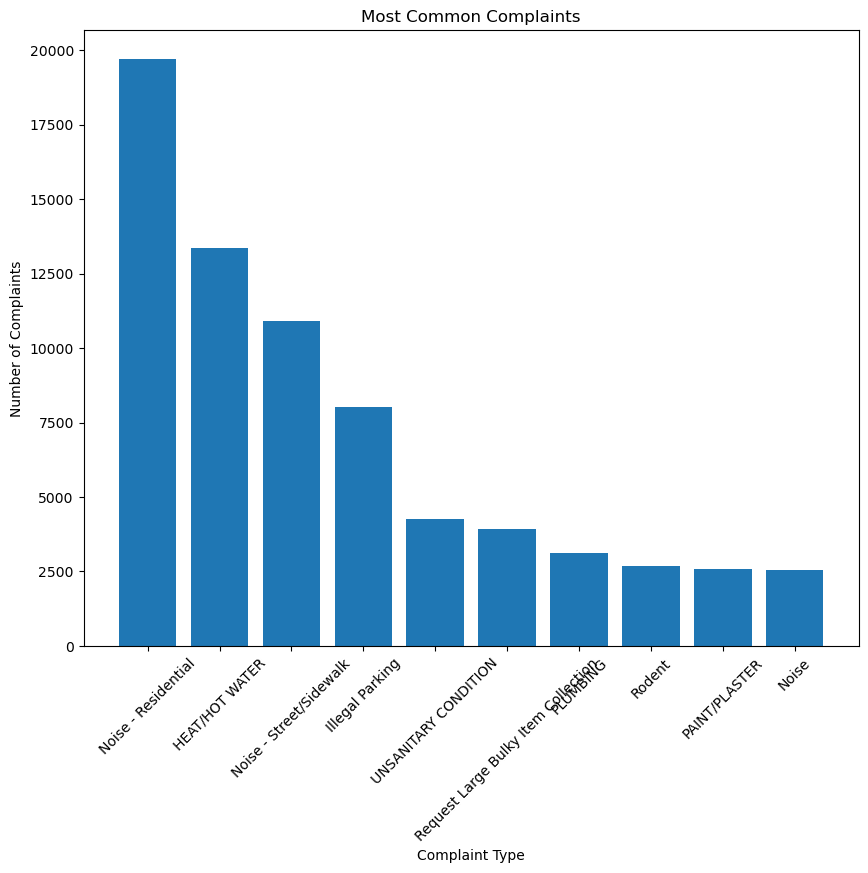

In [76]:
dataframe_for_visual_2 = get_data_for_visual_2()
most_common_complaints(dataframe_for_visual_2)

### Visualization 3

In [77]:
def correlation_with_rents_trees_complaints(dataframe_1, dataframe_2):
    """
    Generate two scatter plots to visualize the correlations between average rents and number of trees,
    and between average rents and number of complaints per zip code.
    
    Parameters:
        dataframe_1 (pd.DataFrame): The input DataFrame containing rent and tree data.
        dataframe_2 (pd.DataFrame): The input DataFrame containing rent and complaint data.
    """
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.scatter(dataframe_1.avg_rent, dataframe_1.num_trees, s=5, color='green')
    plt.ylabel('Number of Trees')
    plt.title('Correlation Between Rents and Trees')

    plt.subplot(2,1,2)
    plt.scatter(dataframe_2.avg_rent, dataframe_2.num_complaints, s=5, color='orange')
    plt.xlabel('Average Rent')
    plt.ylabel('Number of Complaints')
    plt.title('Correlation Between Rents and Complaints')

    plt.show()

In [78]:
def get_data_for_visual_3():
    """
    Retrieve and return data for visualization.

    This function executes two SQL queries to get average rent data, the number of trees,
    and the number of complaints data per zip code within a specific time range.

    Returns:
        result_df_1 (pd.DataFrame): DataFrame containing data for rents and trees.
        result_df_1 (pd.DataFrame): DataFrame containing data for rents and complaints.
    """
    VISUAL_QUERY_3_1 = """
    SELECT
        rents.zipcode,
        AVG(rents.rent) AS avg_rent,
        COUNT(DISTINCT trees.id) AS num_trees
    FROM
        rents
    LEFT JOIN
        trees ON rents.zipcode = trees.zipcode
    WHERE trees.status = 'Alive'
    GROUP BY
        rents.zipcode
    """

    VISUAL_QUERY_3_2 = """
    SELECT
        rents.zipcode,
        AVG(rents.rent) AS avg_rent,
        COUNT(DISTINCT complaints.id) AS num_complaints
    FROM
        rents
    LEFT JOIN
        complaints ON rents.zipcode = complaints.zipcode
    WHERE
        complaints.date BETWEEN TIMESTAMP '2015-01-01 00:00:00' AND TIMESTAMP '2023-09-30 23:59:59'
    GROUP BY
        rents.zipcode
    """

    result_df_1 = pd.read_sql_query(VISUAL_QUERY_3_1, engine)
    result_df_2 = pd.read_sql_query(VISUAL_QUERY_3_2, engine)
    
    return result_df_1, result_df_2

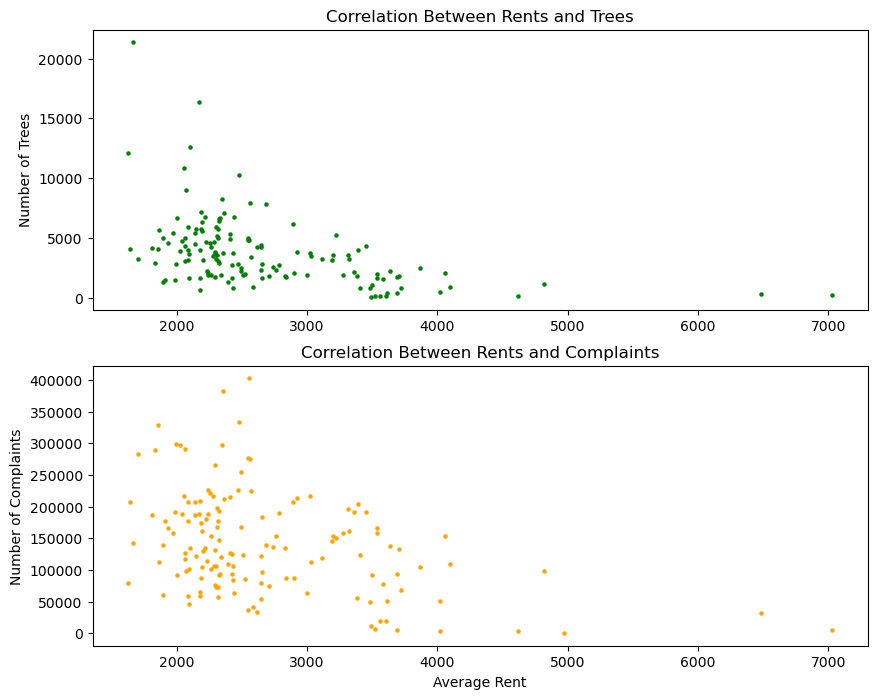

In [79]:
dataframe_for_visual_3_1, dataframe_for_visual_3_2 = get_data_for_visual_3()
correlation_with_rents_trees_complaints(dataframe_for_visual_3_1, dataframe_for_visual_3_2)

### Visualization 4

In [80]:
def rents_and_complaints(dataframe):
    """
    Generate a boxplot to visualize the relationship between rents and number of complaints.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing complaint data.
    """
    data_series = [dataframe.loc[dataframe['bin'] == label, 'num_complaints'] for label in sorted(dataframe['bin'].unique())]

    plt.figure(figsize=(10, 8))
    plt.boxplot(data_series, labels=sorted(dataframe['bin'].unique()))
    plt.xlabel('Average Rent in Sep 2023')
    plt.ylabel('Number of Complaints')
    plt.title('Rent and Complaints')
    plt.show()

In [81]:
def get_data_for_visual_4():
    """
    Retrieve and return data for visualization.
    
    This function executes a SQL query to get average rent data in September 2023
    and complaints data in each zip code within a specific time range.

    Returns:
        result_df (pd.DataFrame): DataFrame containing the query results.
    """
    VISUAL_QUERY_4 = """
    SELECT
        complaints.zipcode,
        AVG(rents.rent) AS september_rent,
        COUNT(*) AS num_complaints
    FROM
        complaints
    JOIN
        rents ON complaints.zipcode = rents.zipcode
    WHERE
        complaints.date BETWEEN TIMESTAMP '2022-10-01 00:00:00' AND TIMESTAMP '2023-09-30 23:59:59'
        AND EXTRACT(MONTH FROM rents.date) = 9 AND EXTRACT(YEAR FROM rents.date) = 2023
    GROUP BY
        complaints.zipcode
    ORDER BY
        september_rent DESC;
    """

    result_df = pd.read_sql_query(VISUAL_QUERY_4, engine)
    bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
    result_df['bin'] = pd.cut(result_df['september_rent'], bins, labels=[f'${i}-{j}' for i, j in zip(bins[:-1], bins[1:])])

    return result_df

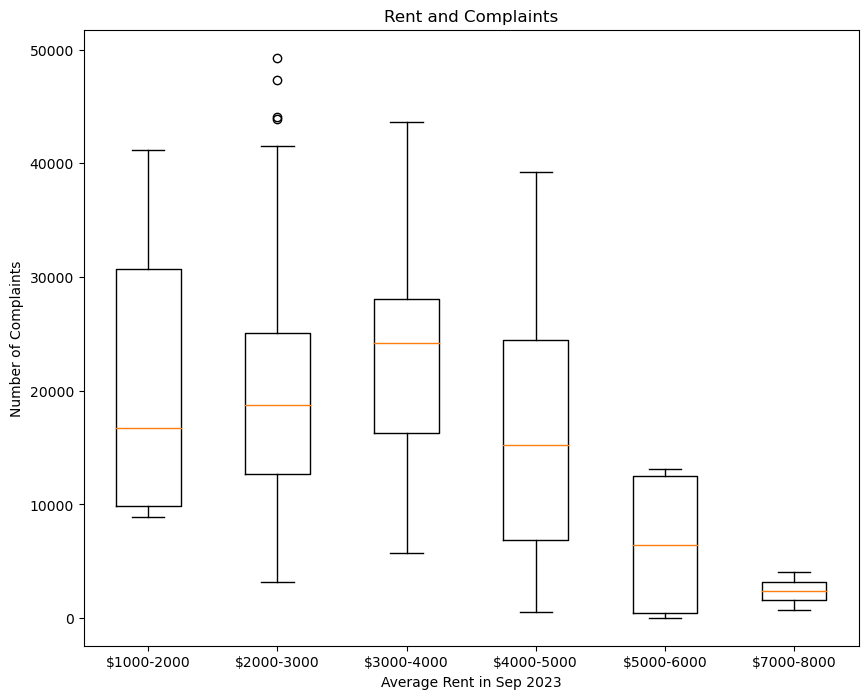

In [82]:
dataframe_for_visual_4 = get_data_for_visual_4()
rents_and_complaints(dataframe_for_visual_4)

### Visualization 5

In [83]:
def coordinates_of_reported_311_incidents(dataframe):
    """
    Plots a geospatial map of 311 incidents.

    This function takes a GeoDataFrame containing the coordinates of 311 incidents and plots them 
    on a map. Each point on the map represents a reported incident. The plot is useful for visualizing 
    the geographical distribution of incidents within the specified area and time frame.

    Parameters:
        gpd.GeoDataFrame: A GeoDataFrame containing the coordinates of the reported 311 incidents.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    dataframe.plot(ax=ax, markersize=5)
    ax.set_title("Reported 311 Incidents from Jan 1, 2023 to Sep 30, 2023")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

In [91]:
def get_data_for_visual_5():
    """
    Retrieves the coordinates of 311 incidents reported within a specific radius and time frame.

    This function queries the database for 311 incidents that occurred between January 1st, 2023,
    and September 30th, 2023, and within a 1-kilometer radius of a given coordinate point. 
    It returns a GeoDataFrame containing the latitude and longitude of each incident.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the coordinates of the reported incidents.
    """
    VISUAL_QUERY_5 = """
    SELECT 
        ST_Y(geometry) AS latitude, 
        ST_X(geometry) AS longitude
    FROM 
        complaints
    WHERE 
        ST_DWithin(
            geometry::geography, 
            ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467)::geography, 4326), 
            1000
        )
      AND 
        date_trunc('day', date) >= '2023-01-01' 
      AND 
        date_trunc('day', date) <= '2023-09-30'
    """
    
    result_df = pd.read_sql_query(VISUAL_QUERY_5, engine)

    result = gpd.GeoDataFrame(
        result_df,
        geometry=gpd.points_from_xy(result_df.longitude, result_df.latitude)
    )

    return result

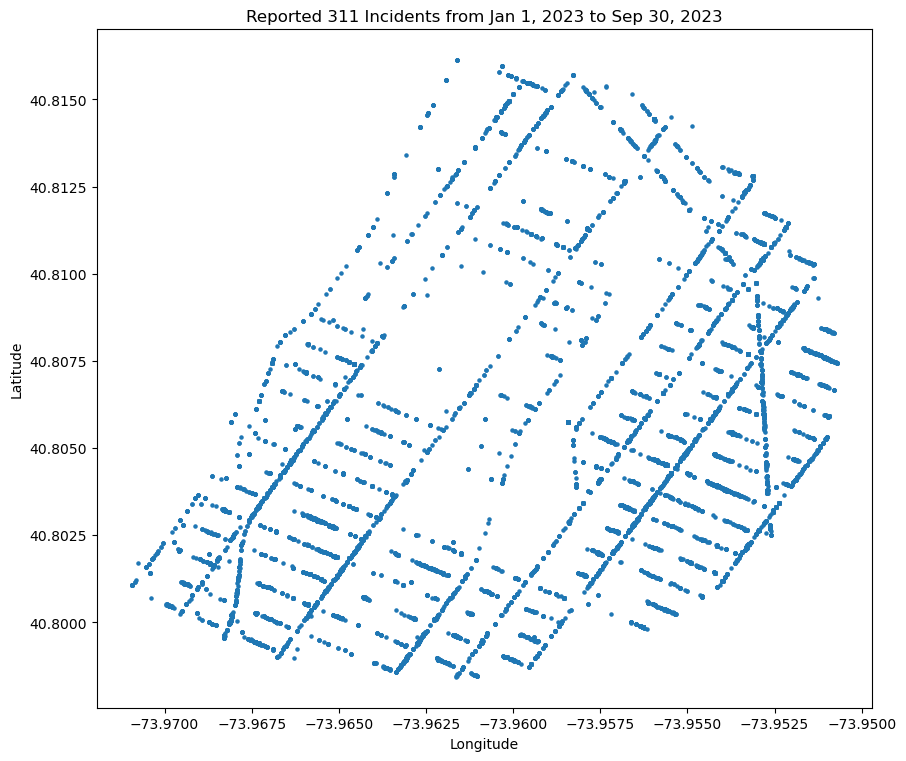

In [92]:
dataframe_for_visual_5 = get_data_for_visual_5()
coordinates_of_reported_311_incidents(dataframe_for_visual_5)

### Visualization 6

In [86]:
def trees_and_tree_requests(dataframe_1, dataframe_2):
    """
    Generate a bar chart to visualize the most common complaints.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing complaint data.
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(dataframe_1.longitude, dataframe_1.latitude, s=5, label='Trees')
    plt.scatter(dataframe_2.longitude, dataframe_2.latitude, s=5, label='Complaints')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Trees and New Tree Request Complaints')
    plt.legend()
    plt.show()

In [87]:
def get_data_for_visual_6():
    """
    Retrieve and return data for visualization.

    This function executes two SQL queries to get the coordinates of trees,
    and the coordinates of New Tree Request within a specific time range.

    Returns:
        result_1 (gpd.GeoDataFrame): GeoDataFrame containing trees data.
        result_2 (gpd.GeoDataFrame): GeoDataFrame containing complaints data.
    """
    VISUAL_QUERY_6_1 = """
    SELECT
        ST_X(geometry) AS longitude,
        ST_Y(geometry) AS latitude
    FROM
        trees
    WHERE status = 'Alive'
    """

    VISUAL_QUERY_6_2 = """
    SELECT
        ST_X(geometry) AS longitude,
        ST_Y(geometry) AS latitude
    FROM
        complaints
    WHERE
        complaint_type = 'New Tree Request' AND
        complaints.date BETWEEN TIMESTAMP '2018-10-01 00:00:00' AND TIMESTAMP '2023-09-30 23:59:59'
    """

    result_df_1 = pd.read_sql_query(VISUAL_QUERY_6_1, engine)
    result_df_2 = pd.read_sql_query(VISUAL_QUERY_6_2, engine)

    result_1 = gpd.GeoDataFrame(
        result_df_1,
        geometry=gpd.points_from_xy(result_df_1.longitude, result_df_1.latitude)
    )
    result_2 = gpd.GeoDataFrame(
        result_df_2,
        geometry=gpd.points_from_xy(result_df_2.longitude, result_df_2.latitude)
    )

    return result_1, result_2

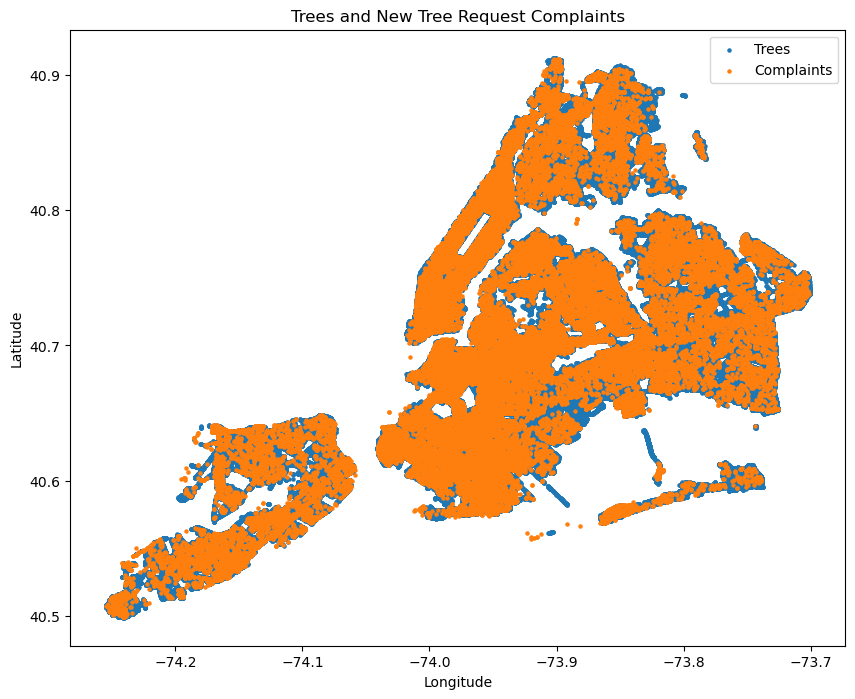

In [88]:
dataframe_for_visual_6_1, dataframe_for_visual_6_2 = get_data_for_visual_6()
trees_and_tree_requests(dataframe_for_visual_6_1, dataframe_for_visual_6_2)